<a href="https://colab.research.google.com/github/nyjinnn/images/blob/main/Chapter7_%EC%88%98%EC%97%85!%20(220715).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np 

### 1. 데이터셋 준비하기

In [41]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


In [42]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [43]:
class_names = ["T-shirts", "Pants", "Sweater", "Dress", "Coat", "Sandal", "Shirts", "Sneakers", "Bag", "Boots"]

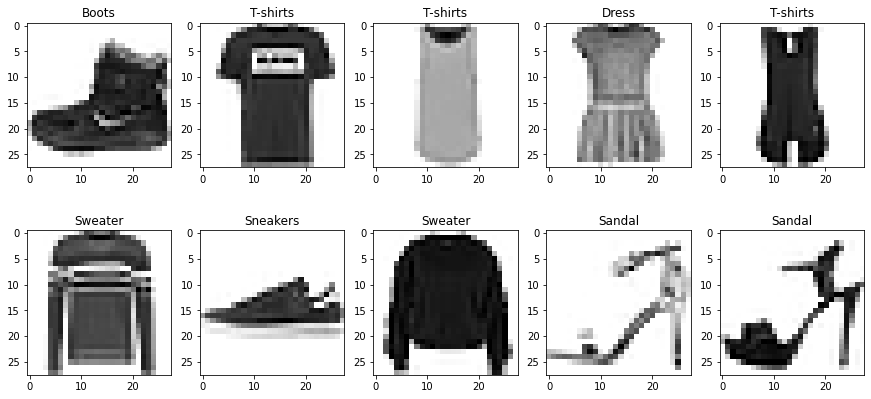

In [44]:
fig = plt.figure(figsize=(15, 7))

for i in range(10):
    plottable_image = np.reshape(x_train_all[i], (28, 28))
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_train_all[i]])
    ax.imshow(plottable_image, cmap='gray_r')

In [45]:
from sklearn.model_selection import train_test_split 
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [46]:
print("학습 데이터셋 클래스별 샘플 수 : ", np.bincount(y_train))
print("평가 데이터셋 클래스별 샘플 수 : ", np.bincount(y_valid))

학습 데이터셋 클래스별 샘플 수 :  [4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
평가 데이터셋 클래스별 샘플 수 :  [1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [47]:
x_train = x_train / 255    #0부터 1까지의 값으로 변환
x_valid = x_valid / 255 
x_test = x_test / 255 

In [48]:
x_train_reshape = x_train.reshape(-1, 784) #28x28 데이터 > 784로 변환
x_valid_reshape = x_valid.reshape(-1, 784)
x_test_reshape = x_test.reshape(-1, 784)

print("학습 데이터 셋의 형태 : ", x_train_reshape.shape)
print("검증 데이터 셋의 형태 : ", x_valid_reshape.shape)

학습 데이터 셋의 형태 :  (48000, 784)
검증 데이터 셋의 형태 :  (12000, 784)


### 2. 원핫 인코딩하기

In [49]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [50]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_valid_encoded = tf.keras.utils.to_categorical(y_valid)

In [51]:
print(y_train[0], y_train_encoded[0], class_names[y_train[0]])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] Shirts


In [52]:
import torch
x_train_torch = torch.FloatTensor(x_train_reshape)
y_train_torch = torch.FloatTensor(y_train_encoded)
x_valid_torch = torch.FloatTensor(x_valid_reshape)
y_valid_torch = torch.FloatTensor(y_valid_encoded) 
x_test_torch = torch.FloatTensor(x_test_reshape)
y_test_torch = torch.FloatTensor(y_test)

### 3. 신경망 만들기

In [53]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [54]:
class FashionDataset(Dataset):
  def __init__(self, x, y):
    self.x_data = x
    self.y_data = y
  
  def __getitem__(self, index):
    x = self.x_data[index]
    y = self.y_data[index]
    return x, y
  
  def collate_fn(self, batch):
    x, y = zip(*batch) #batch 사이즈만큼 커짐
    return x, y

  def __len__(self):
    return len(self.x_data)

In [55]:
dataset = FashionDataset(x_train_torch, y_train_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, drop_last=True)

In [56]:
for b in dataloader:
    x_batch=b[0]
    y_batch=b[1]
    print("배치사이즈:", len(x_batch))
    print("데이터 크기:", (x_batch.size))
    print("타겟 크기:", (y_batch.size))
    break

배치사이즈: 32
데이터 크기: <built-in method size of Tensor object at 0x7f52e9cc8fb0>
타겟 크기: <built-in method size of Tensor object at 0x7f52e9cc80b0>


In [57]:
from tqdm import tqdm 
import random 

random_seed = 123
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

model = nn.Sequential(
    nn.Linear(784, 100),
    nn.ReLU(), 
    nn.Linear(100, 10)
    )

optim = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

global_step = 0 
for epoch in range(10):
  t = tqdm(dataloader, ncols=100)
  for i, batch in enumerate(t):
    x_batch = batch[0]
    y_batch = batch[1]
    output = model(x_batch)
    loss = criterion(output, y_batch)
    model.zero_grad() 
    optim.zero_grad()
    loss.backward() #gradiant(기울기)구하고
    optim.step()    #적용(업데이트)

    global_step += 1
    t.set_description("epoch: {} | global_step: {:8d} | loss: {:.4f}".format(epoch + 1, global_step, loss))

  predicts = model(x_valid_torch)
  predicts = torch.argmax(predicts, 1)

  correct = 0 
  for i in range(len(predicts)):
    if predicts[i].item() == y_valid[i]: #torch에서 scalar(값) 가져오는 것 (item함수)
      correct += 1
  acc = correct / len(predicts)
  print("epoch: {} | global_step: {} | valid acc: {:%}".format(epoch + 1, global_step, acc))

epoch: 1 | global_step:     1500 | loss: 0.6852: 100%|█████████| 1500/1500 [00:09<00:00, 154.38it/s]


epoch: 1 | global_step: 1500 | valid acc: 80.475000%


epoch: 2 | global_step:     3000 | loss: 0.4901: 100%|█████████| 1500/1500 [00:09<00:00, 154.04it/s]


epoch: 2 | global_step: 3000 | valid acc: 83.016667%


epoch: 3 | global_step:     4500 | loss: 0.6082: 100%|█████████| 1500/1500 [00:09<00:00, 151.23it/s]


epoch: 3 | global_step: 4500 | valid acc: 84.150000%


epoch: 4 | global_step:     6000 | loss: 0.7648: 100%|█████████| 1500/1500 [00:09<00:00, 154.88it/s]


epoch: 4 | global_step: 6000 | valid acc: 85.000000%


epoch: 5 | global_step:     7500 | loss: 0.5250: 100%|█████████| 1500/1500 [00:09<00:00, 151.66it/s]


epoch: 5 | global_step: 7500 | valid acc: 85.383333%


epoch: 6 | global_step:     9000 | loss: 0.5153: 100%|█████████| 1500/1500 [00:09<00:00, 153.29it/s]


epoch: 6 | global_step: 9000 | valid acc: 85.575000%


epoch: 7 | global_step:    10500 | loss: 0.6055: 100%|█████████| 1500/1500 [00:09<00:00, 152.47it/s]


epoch: 7 | global_step: 10500 | valid acc: 85.425000%


epoch: 8 | global_step:    12000 | loss: 0.3786: 100%|█████████| 1500/1500 [00:11<00:00, 132.55it/s]


epoch: 8 | global_step: 12000 | valid acc: 86.258333%


epoch: 9 | global_step:    13500 | loss: 0.5760: 100%|█████████| 1500/1500 [00:09<00:00, 152.53it/s]


epoch: 9 | global_step: 13500 | valid acc: 86.475000%


epoch: 10 | global_step:    15000 | loss: 0.2206: 100%|████████| 1500/1500 [00:09<00:00, 150.15it/s]


epoch: 10 | global_step: 15000 | valid acc: 86.616667%


In [58]:
predict = model(x_test_torch)
predict = torch.argmax(predict, 1)

In [59]:
correct = 0 
for i in range(len(predict)):
  if predict[i].item() == y_test[i]:
    correct += 1
acc = correct/len(predict)
print("Test accuracy : {:.2%}".format(acc))

Test accuracy : 84.91%


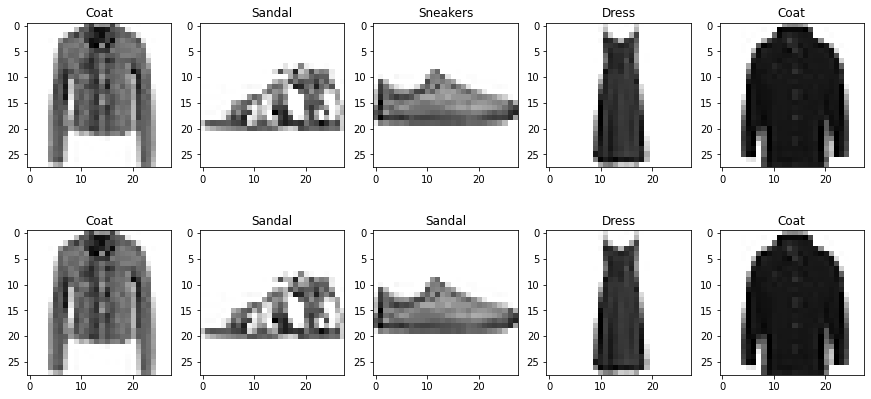

In [60]:
fig = plt.figure(figsize=(15, 7))

for i in range(5):
    plottable_image = x_test[i+10]
    ax = fig.add_subplot(2, 5, i+1)
    ax.title.set_text(class_names[y_test[i+10]])
    ax.imshow(plottable_image, cmap='gray_r')
  
for i in range(5):
    plottable_image = x_test[i+10]
    ax = fig.add_subplot(2, 5, i+6)
    ax.title.set_text(class_names[predict[i+10].item()])
    ax.imshow(plottable_image, cmap='gray_r')

plt.show()